In [0]:
from __future__ import print_function, division

# Torch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
# Misc Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
import zipfile
from PIL import Image
import copy
# Google Drive Import
from google.colab import drive
drive.mount('/content/drive/')
# Own File Imports
class_pth = '/content/drive/My Drive/Machine_Learning/saved_models/Salient_Object_Detection/models/'
sys.path.insert(1, class_pth)

from amuletnet_full import AmuletNet
from MSRA10k_class import get_trainloader, extract_data, extract
from train import train_model


In [0]:
pth = '/content/drive/My Drive/Machine_Learning/Datasets/MSRA10k/msra10kbgr.zip'

extract(pth)

x_pth = '/content/msra10kbgr/input_images.npy'
y_pth = '/content/msra10kbgr/ground_truth.npy'


In [0]:

X, Y = extract_data(x_pth, y_pth)
train_loader, val_loader = get_trainloader(X, Y)

Done!


In [0]:
# gpu device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16 = models.vgg16(pretrained= True)

cuda:0


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 59.8MB/s]


In [0]:
# Instantiate Class and Optimizers
model = AmuletNet(vgg16)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-4)

In [0]:
# Only Use if you want to train the model
save_pth = '/content/drive/My Drive/Machine_Learning/saved_models/Salient_Object_Detection/full_version_1/checkpointv4_x'
num_epochs = 20
load_pt = 0
model, losses = train_model(model, train_loader, criterion, optimizer, num_epochs, save_pth, load_pt, device)




In [0]:
# For Testing 
# Keep in mind that previous versions have different classes and so torch.load will fail if you attempt to load them
load_pt = 15
load_pth = '/content/drive/My Drive/Machine_Learning/saved_models/Salient_Object_Detection/full_version_1/checkpointv4_' + str(load_pt) + '.pth'
checkpoint = torch.load(load_pth)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

<All keys matched successfully>

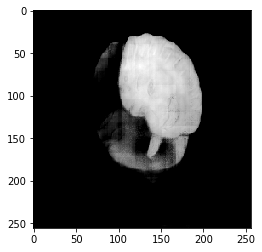

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


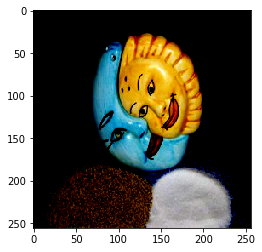

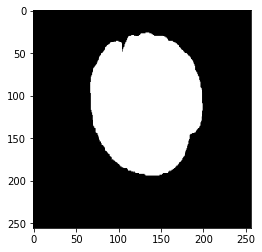

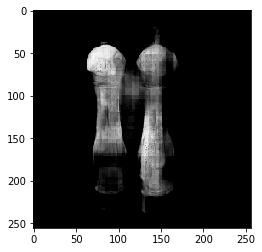

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


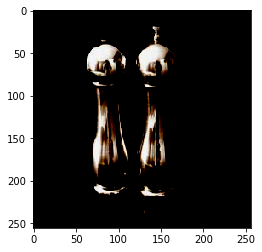

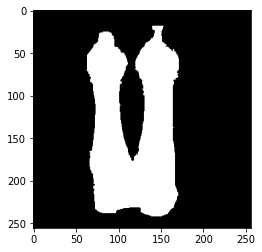

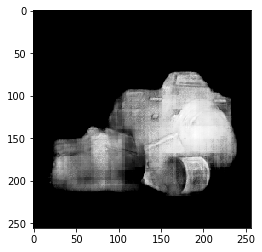

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


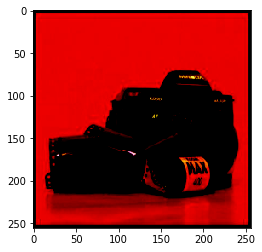

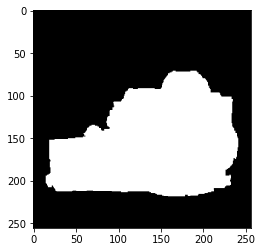

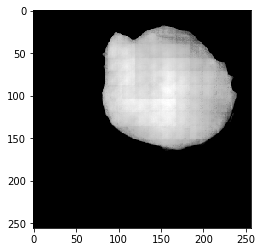

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


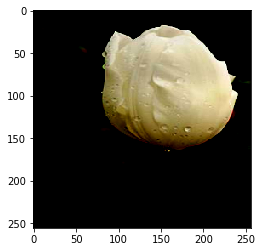

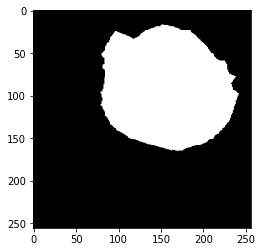

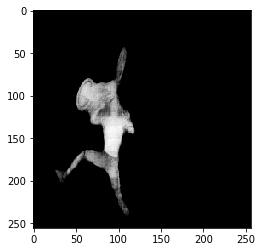

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


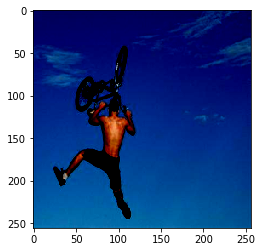

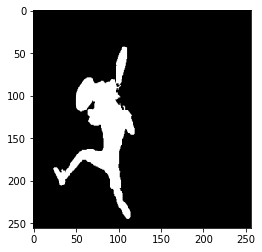

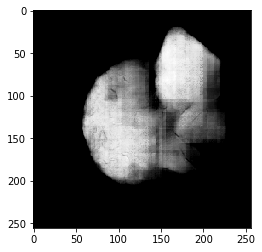

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


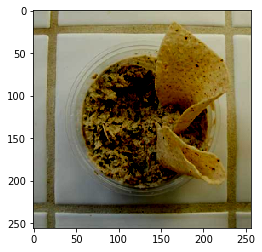

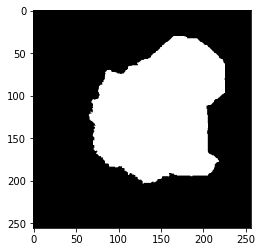

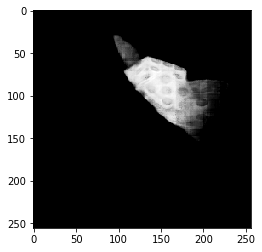

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


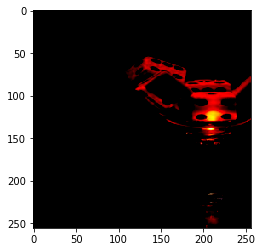

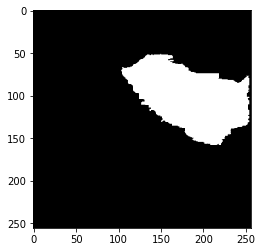

In [0]:
count = 0

for val_images, val_labels in val_loader:

  if count > 6:
    break

  val_images = val_images.to(device)
  val_labels = val_labels.squeeze()

  fusion_prediction, multi_level_preds = model(val_images)

  val_images = val_images.detach().cpu()
  val_labels = val_labels.detach().cpu()

  fusion_prediction = fusion_prediction.squeeze()

  delta_fusion_map = fusion_prediction[1][:] - fusion_prediction[0][:]

  for excitation_map in multi_level_preds:
    excitation_map = excitation_map.squeeze()
    delta_fusion_map += excitation_map[1][:] - excitation_map[0][:]

  delta_fusion_map /= len(multi_level_preds) + 1
  Final_Prediction = nn.functional.relu(delta_fusion_map)
  Final_Prediction = Final_Prediction.detach().cpu()

  plt.imshow(Final_Prediction, cmap='gray')
  plt.show()

  plt.imshow(val_images.squeeze().permute(1,2,0))
  plt.show()

  plt.imshow(val_labels, cmap='gray')
  plt.show()
  count += 1


In [0]:
def get_pred(fusion_pred, multi_level_preds):
  fusion_pred = fusion_pred.squeeze()
  delta_fusion_map = fusion_pred[1][:] - fusion_pred[0][:]

  for excitation_map in multi_level_preds:
    excitation_map = excitation_map.squeeze()
    delta_fusion_map += excitation_map[1][:] - excitation_map[0][:]

  delta_fusion_map /= len(multi_level_preds) + 1
  Final_Prediction = nn.functional.relu(delta_fusion_map)

  return Final_Prediction


In [0]:
# Compute Evaluation Metrics
precision = 0
recall = 0
beta = 0.3
f_measure = 0
fpr = 0
MAE = 0

with torch.set_grad_enabled(False):
  for i, (val_images, val_labels) in enumerate(val_loader):
    print(i)
    val_images = val_images.to(device)
    val_labels = val_labels.to(device)
    fusion, list_pred = model(val_images)
    
    val_pred = get_pred(fusion, list_pred)
    # Normalize Image
    val_pred = val_pred/val_pred.max()
    binary_val_pred = torch.round(val_pred)
    val_labels = torch.round(val_labels)

    G = val_labels.sum()
    M = binary_val_pred.sum()
    MnG = torch.mul(binary_val_pred, val_labels).sum()
    Mn_notG = M-MnG
    
    precision += MnG/M
    recall += MnG/G
    fpr += Mn_notG/G
    MAE += torch.abs(val_pred - val_labels).mean()

precision /= 2000 
recall /= 2000
f_measure /= 2000
fpr /= 2000
MAE /= 2000

print('precision: ', precision)
print('recall: ', recall)
print('f_measure: ', f_measure)
print('False-Positive-Rate: ', fpr)
print('MAE: ', MAE)